## Backgound
Analysis of the Chemotaxis model described by Spiro et al., PNAS, 1999.
The model describes the receptor state along 3 dimensions:
  - bound to a ligand
  - phosphorylated
  - degree of methylation (considers 2, 3, 4)
  
Key variables are:
   - Y, Yp - concentrations of CheY and its phosphorylated form
   - B, Bp - concentrations of CheB and its phosphorylated form
   - L - ligand concentration
   - f<state>, t<state> - "f" indicates the fraction of the concentration in the state, "t" is the total
     <state> is a 3 character string, such as "TT2". T/F indicates the boolean value; the last is an integer.
     
Below is a figure from Spiro describing the state structure of receptors.

Issues
 - yaxis labels are not showing
 - Overshoot steady state YP
 - Not getting correct time response for YP

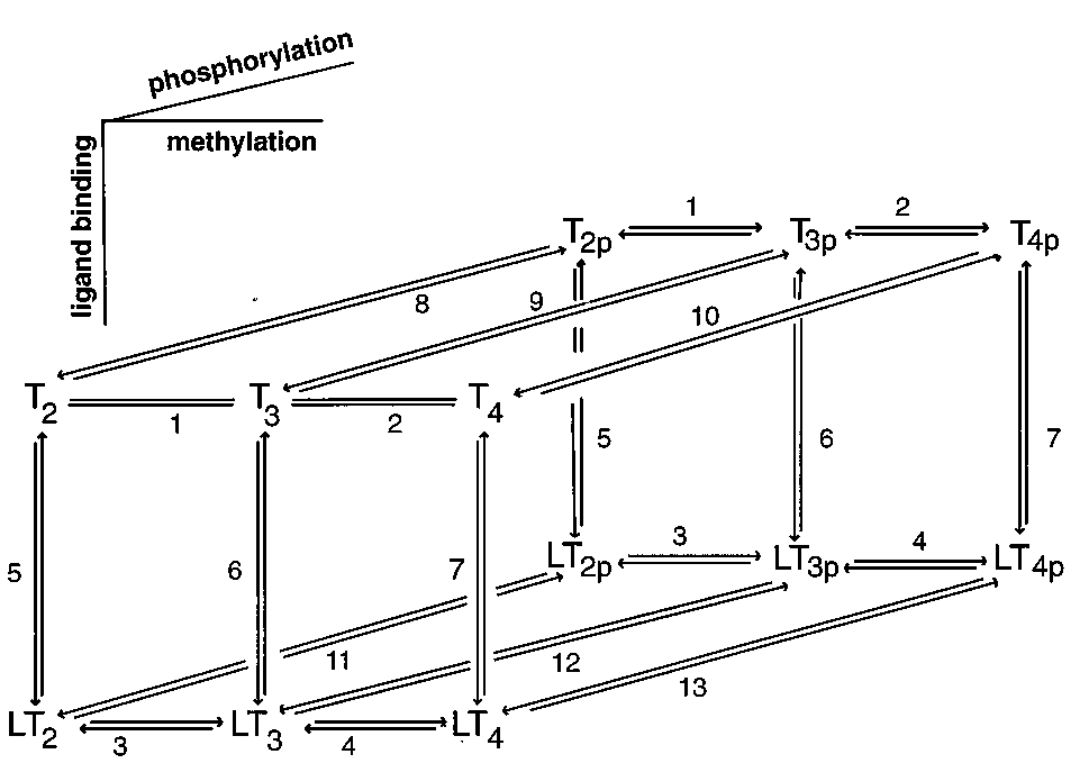

In [1]:
from IPython.display import Image, display
display(Image(filename='img/receptor_states.png'))

## Summary

Initially, we consider a step response. Later, we repeat the same analysis for a ramp. These correspond to the analyses done by Spiro.

Most of the analysis is done using fractional concentrations (variables that begin with "f"). We begin by justifying this.

Next, we analyze the effects of a step response. "Perfect adaptation" is possible if the step is small enough.

## Software Dependencies
The model and various utility functions are in the python modules chemotaxis_model and data_plotter.

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tellurium as te
from chemotaxis_model import ChemotaxisModel, StateAggregationFactory
from data_plotter import DataPlotter
model = ChemotaxisModel()

/home/ubuntu/miniconda2/lib/python2.7/site-packages/tellurium/notebooks/__init__.py:16: UserWarning: Notebook tools are not imported, due to missing dependencies.
  warnings.warn("Notebook tools are not imported, due to missing dependencies.")


## Antimony Model

In [3]:
# This is the templated model
print model.getModel()

# Template file for the Spiro model of chemotaxis in PNAS, 1999.
# The species B, R, T2, R, Y are specified separately.
#! SbStar Vesion 1.0 {'l': ['L', ''], 'm': ['2', '3', '4'], 'p': ['p', ''], 'r': ['R', '']} 
J0: $x0 -> L; k0*x0
# REACTIONS from Spiro, Table 3
# Methylation
J1_2{p}R: T2{p}R -> T3{p} + R; k1c*T2{p}R
J1_3{p}R: T3{p}R -> T4{p} + R; k2c*T3{p}R
J1_L2{p}R: LT2{p}R -> LT3{p} + R; k3c*LT2{p}R
J1_L3{p}R: LT3{p}R -> LT4{p} + R; k4c*LT3{p}R
# Demethylations.
J4a_3p{r}: T3p{r} + Bp -> T2p{r} + Bp; k_1*T3p{r}*Bp
J4b_4p{r}: T4p{r} + Bp -> T3p{r} + Bp; k_2*T4p{r}*Bp
J4c_L3p{r}: LT3p{r} + Bp -> LT2p{r} + Bp; k_3*LT3p{r}*Bp
J4d_L4p{r}: LT4p{r} + Bp -> LT3p{r} + Bp; k_4*LT4p{r}*Bp
#   Details of *T* + R <-> *T*R
J2_{l}{m}{p}: {l}T{m}{p}R -> {l}T{m}{p} + R; k1a*{l}T{m}{p}R
J3_{l}{m}{p}: {l}T{m}{p} + R -> {l}T{m}{p}R; k1b*{l}T{m}{p}*R
# Ligand binding and unbinding
J5_{m}{p}{r}: L + T{m}{p}{r} -> LT{m}{p}{r}; k5*L*T{m}{p}{r}
J6_{m}{p}{r}: LT{m}{p}{r} -> L + T{m}{p}{r}; k_5*LT{m}{p}{r}

## Common Codes Used in this Analysis

In [5]:
# Runs simulation and creates global variables used in analysis
def sim(elements=None,end=400, concentrations={}):
    """
    Runs the simulation and creates global names
    :param list elements: additions to model
    :param int end: simulation end time
    :param dict concentrations: key is variable, value is assignment
    Output: global variables - plotter, result
    """
    if elements is None:
      elements = []
    global plotter, result, model, rr
    model = ChemotaxisModel()
    for element in elements:
      model.appendToModel(element)
    rr = model.initialize()
    for k,v in concentrations.items():
      rr[k] = v
    result = model.run(end=end)
    plotter = DataPlotter(model)


In [6]:
# Export the XML
#f_sbml = "chemotaxis.xml"
# export current model state
#rr.exportToSBML(f_sbml)
# to export the initial state when the model

## Analysis of Step Response
The goal here is to understand the dynamics of the receptor state for a step response.
From the foregoing, we established that it's sufficient to look at the fraction of receptors that are in the phosphorylated state (since this correlates with Yp). Now we want to understand what substates contribute to phosphorylated receptors.

Spiro shows a step response plot with L going from 0 to 11uM and "perfect adaption of Yp. We do not see this. Possibly, this is because he used a model with more methylation levels. Below is Spiro's step response curve.

### Very Large Step - 1 mM (1,000 times ligand-receptor $K_d$)

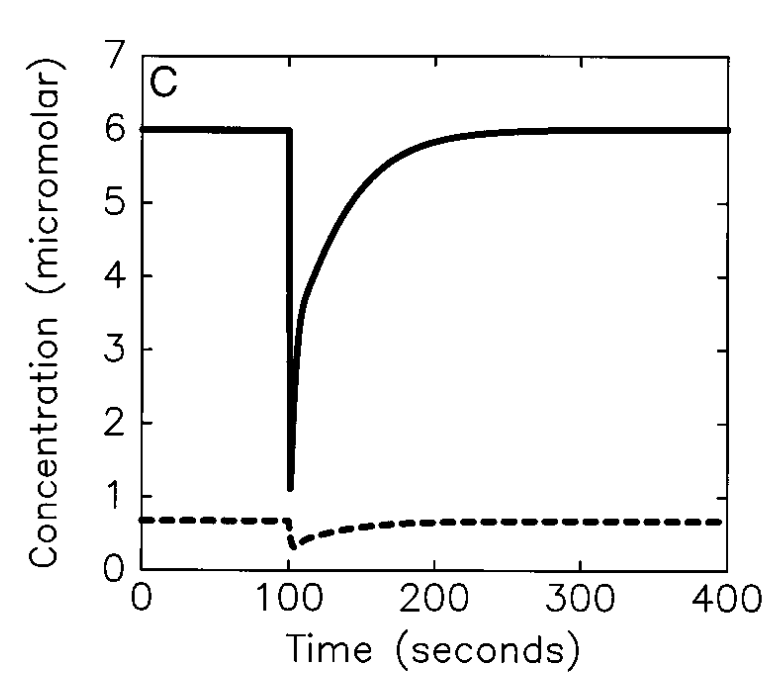

In [7]:
# Spiro's plot for a step response with L=1mM
from IPython.display import Image, display
display(Image(filename='img/spiro_largestep.png'))
# The solid line is Yp

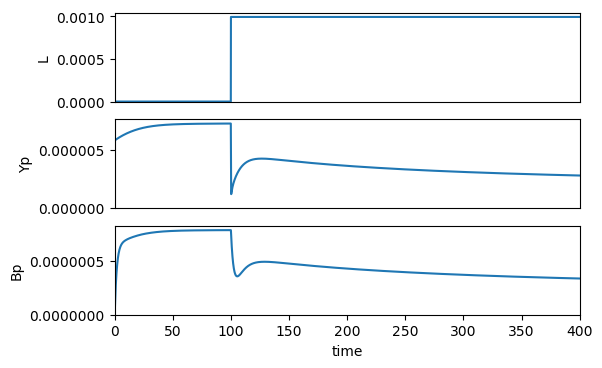

In [8]:
# The amount of ligand is 1000 times the amount of receptors
sim(elements=["at (time > 100): L = 1e-3"])
plotter.lines(["L", "Yp", "Bp"])

Observations
- The steady state after the large step is about Yp=2.5 uM as opposed to Yp=6uM in Spiro.

### Small Step - 0.11 uM  (11% of ligand-receptor $K_d$)

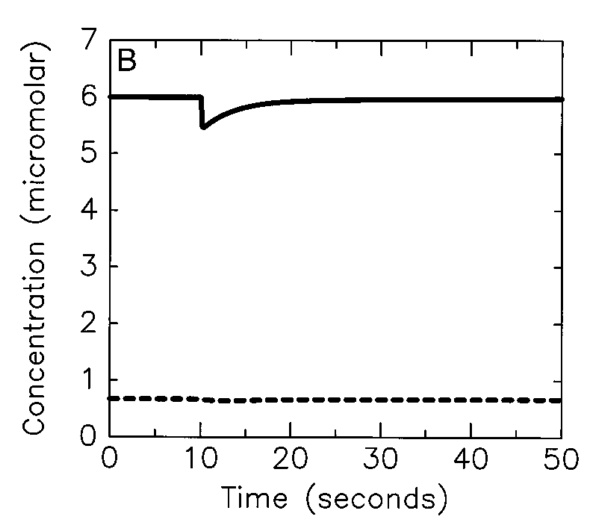

In [9]:
from IPython.display import Image, display
display(Image(filename='img/spiro_0.11.png'))
# The solid line is Yp;

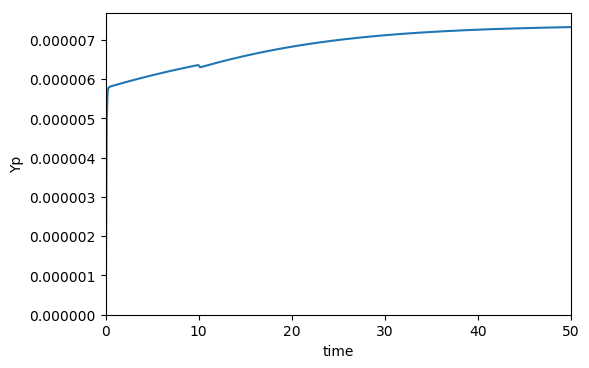

In [10]:
sim(elements=["at (time > 10): L = 0.11e-6"], end=50)
plotter.lines(["Yp"])

Observations
 - Gain is correct. Steady state value of Yp = 6e-6
 - Time constant of disturbance seems about right
 - Magnitude of the disturbance is somewhat less than Spiro (which drops to about 5.5e-6)

### Medium Size Step - 1.1 uM (110% of ligand-receptor $K_d$)

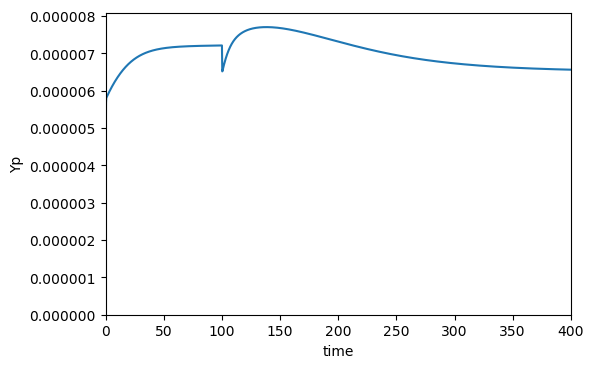

In [11]:
sim(elements=["at (time > 100): L = 1.1e-6"])
plotter.lines(["Yp"])

Observations
- Gain is correct. Steady state value of Yp = 6e-6
- returns to steady state of 6uM
- Magnitude of the disturbance is larger than adding L=11uM, as expected.

### Step Response - 1.8 uM

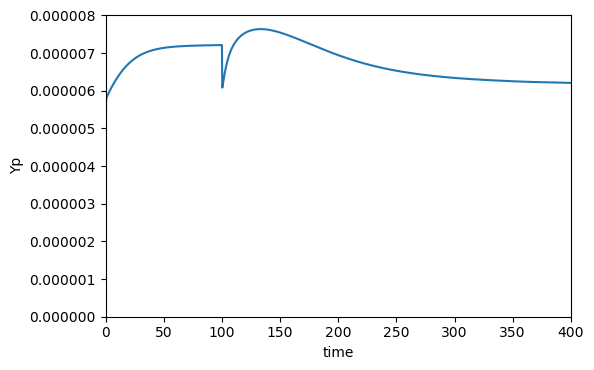

In [12]:
sim(elements=["at (time > 100): L = 1.8e-6"])
plotter.lines(["Yp"])

### Step Response - 4 uM (400% of ligand-receptor $K_d$)

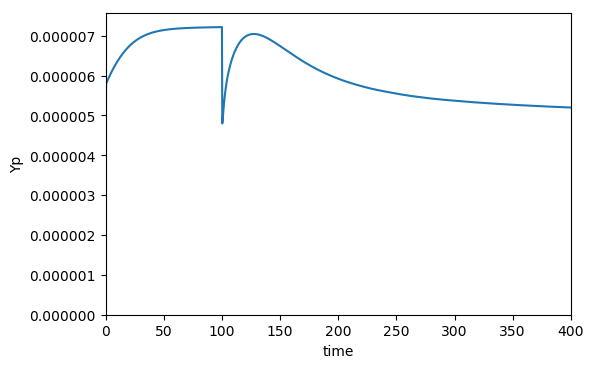

In [13]:
sim(elements=["at (time > 100): L = 4e-6"])
plotter.lines(["Yp"])

### Step Response - 11 uM (138% of ligand-receptor $K_d$)

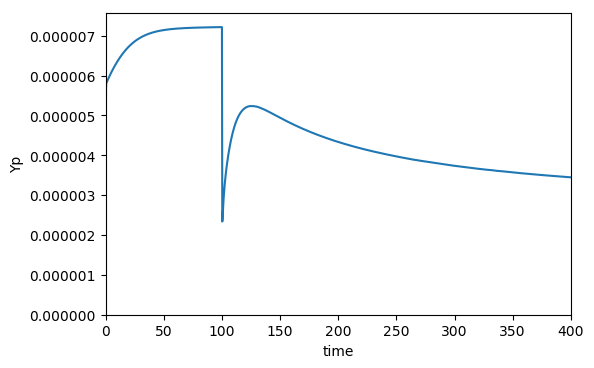

In [14]:
# System is flooded with more ligand than there are receptors. Much more ligand than receptors.
sim(elements=["at (time > 100): L = 11e-6"])
plotter.lines(["Yp"])

# Detailed Analysis of 11 uM Step

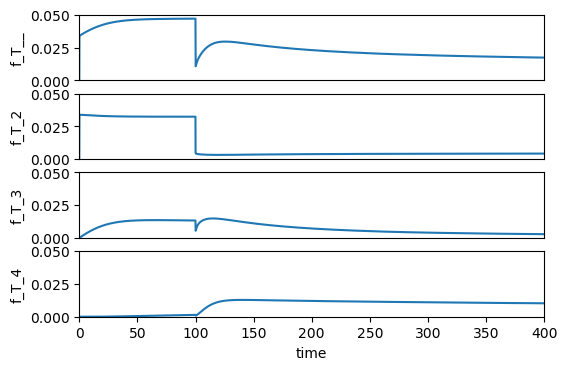

In [15]:
# Breakdown the state phosphorylation state by methylation level
sim(elements=["at (time > 100): L = 11e-6"])
plotter.lines(["f_T__", "f_T_2", "f_T_3", "f_T_4"], yrange=[0,0.05])

Observations
 - Phosphorylation level of receptor does not recover after the Ligands are introduced.
 - See a shift to higher methylation states

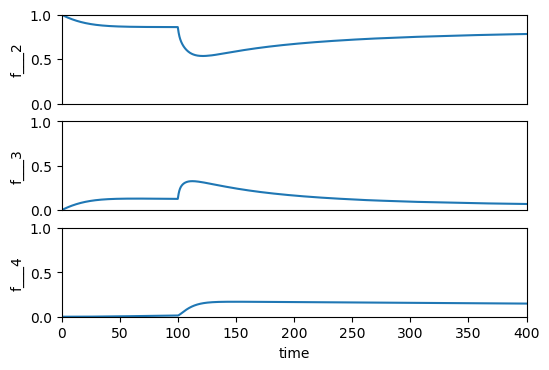

In [16]:
# Analyze the methylation levels
sim(elements=["at (time > 100): L = 11e-6"])
plotter.lines(["f___2", "f___3", "f___4"], yrange=[0,1])

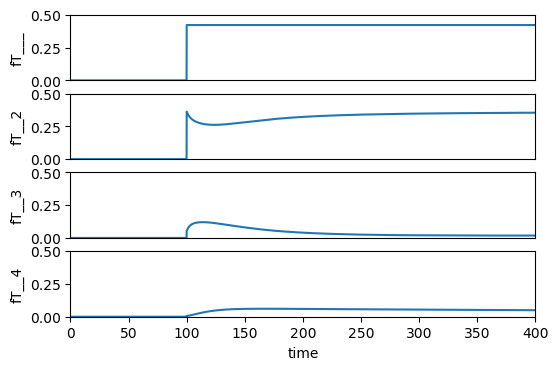

In [17]:
# Analyze the methylation levels for ligand bound receptors
sim(elements=["at (time > 100): L = 4.1e-6"])
plotter.lines(["fT___", "fT__2", "fT__3", "fT__4"], yrange=[0,0.5])

Observations
- Large fraction of LT2 means reduced phosphorylation

Questions
- Why doesn't the LT2 methylate?

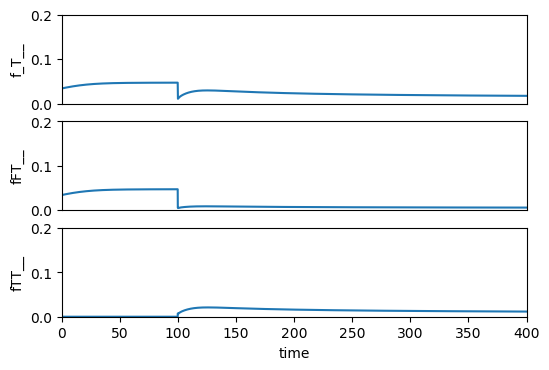

In [18]:
# Breakdown the state phosphorylations by ligand bound
sim(elements=["at (time > 100): L = 11e-6"])
plotter.lines(["f_T__", "fFT__", "fTT__"], yrange=[0, 0.2])

Observations
- Most of the phosphorylation after the step is in receptors with the ligand bound

## Ramp analysis

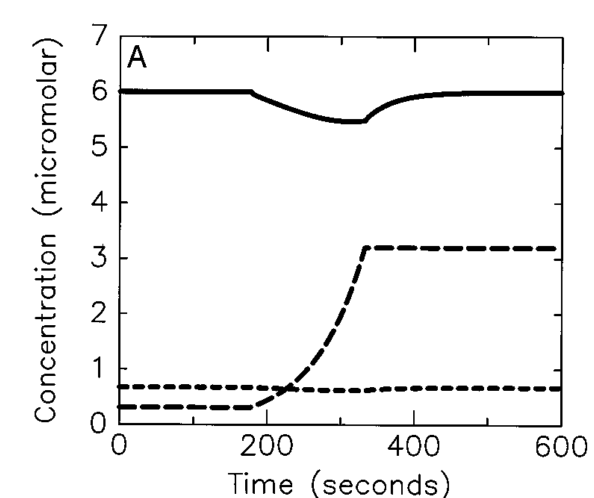

In [19]:
from IPython.display import Image, display
display(Image(filename='img/spiro_ramp.png'))
# The solid line is Yp; the long dashed line is L

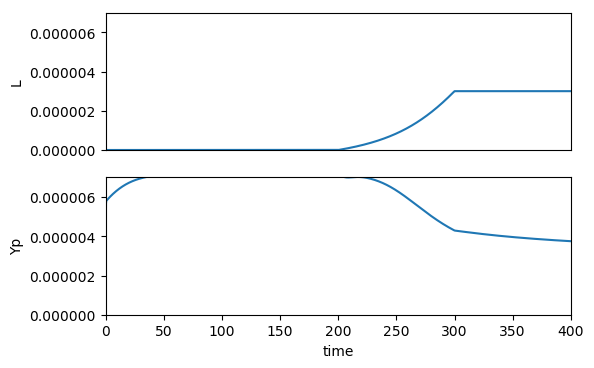

In [20]:
# Ramp analysis for the same conditions as Spiro
elements = ["at (time > 200): k0 = 0.09e-6", "at (time > 300): k0 = 0, L=3e-6"]
sim(elements=elements)
plotter.lines(["L", "Yp"], yrange=[0,7e-6])

Observations
- Initial response is good, but then the steady state state Yp is much lower than Spiro.
- Am I correctly interpreting how the experiment was done? That is, I see the amount of free L, not the total L in the system, which must consider TL as well.


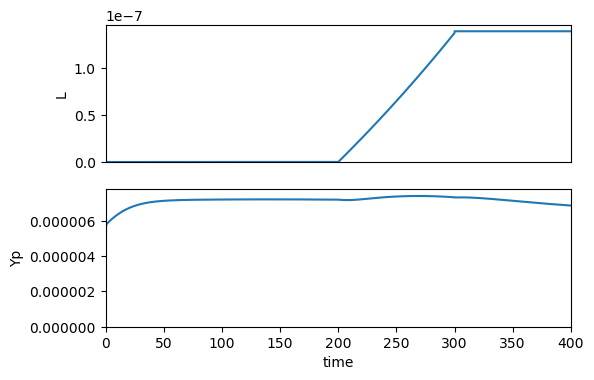

In [21]:
# Gradually add 1.1uM of ligand
elements = ["at (time > 200): k0 = 0.011e-6", "at (time > 300): k0 = 0, L=0.15e-6"]
sim(elements=elements)
plotter.lines(["L", "Yp"])

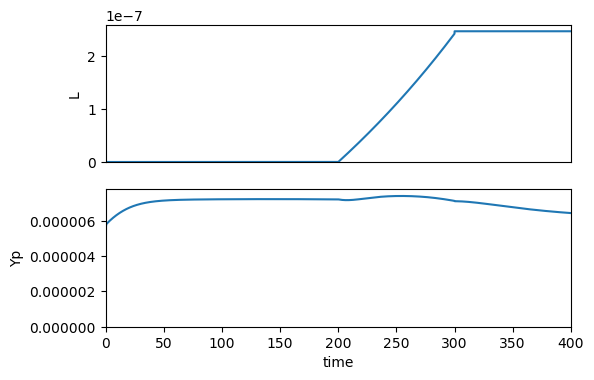

In [22]:
# See how much ligand I can add and still get the same steady state response. Added a total of 1.8uM.
elements = ["at (time > 200): k0 = 0.018e-6", "at (time > 300): k0 = 0, L=0.27e-6"]
sim(elements=elements)
plotter.lines(["L", "Yp"])

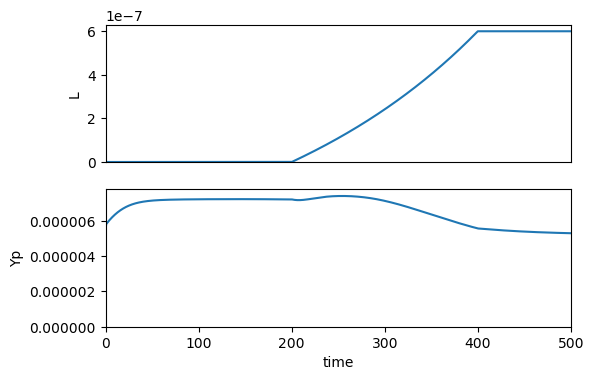

In [23]:
# Pushing the ramp a bit longer.
elements = ["at (time > 200): k0 = 0.018e-6", "at (time > 400): k0 = 0, L=0.6e-6"]
sim(elements=elements, end=500)
plotter.lines(["L", "Yp"])

# Ligand Binding Analysis

This section provides an analytical validation of one quantity in the simulation, the fraction of ligand bound receptors. The analysis is based on a simple equilibrium analysis.
- $K_d = 1uM$ is the disassociation constant for the reaction $TL \rightleftharpoons T + L$, where $T$ is the receptor and $L$ is the ligand.
- $r$ is the ratio $\frac{L_{TOT}}{T_{TOT}}$, where $L_{TOT}$ is the total amount of ligand and $T_{TOT}$ is the total number of receptors.

In [24]:
Kd = 1e-6 # 1 micromolar
TTOT = 8  # 8 micro molars
K = Kd/(TTOT*1e-6)

In [25]:
import numpy as np
def fBound(r, K=K):
    """
    Using steady state analysis to compute the fraction of ligand bound to receptors
    :param float r: ratio of total L to total T
    :param float K: ratio of Kd to total T
    :return float: fraction of ligand bound to receptors
    """
    result = None
    b = -(1 + r + K)
    term1 = -b/2
    term2 = np.sqrt(b**2-4*r)/2
    result1 = term1 - term2
    result2 = term1 + term2
    if result1 <= 1.0 and result1 >= 0:
        result = result1
    if result2 <= 1.0 and result2 >= 0:
        if result is not None:
            raise RuntimeError("Two valid solutions")
        else:
            result = result1
    if result is None:
        raise RuntimeError("No valid solution.")
    return result

def evaluateEstimateError(L):
    """
    Returns the error of expected fraction of ligand bound compared with the values
    obtained from simulation.
    """
    sim(elements=["at (time > 100): L = %s" % (L*1e-6)])
    actual = model.getVariable("fT___")[-1]  # Get the last (steady state) value
    expected = fBound(L/TTOT)
    return (expected -actual)/actual

In [26]:
evaluateEstimateError(4.1)

8.6019869720917617e-05

In [27]:
evaluateEstimateError(1.1)

0.00011654867547458415

In [28]:
evaluateEstimateError(0.1)

0.011388230485236305

Observations
- Good agreement between the analytic prediction and the simulation.

# Conclusions and Questions

- Get results comparable to Spiro for ligand concentrations ~100% of $K_d$, the disassciation constant for ligand-receptor binding.
- For large ligand concentrations, we don't get agreement with Spiro.

Questions
- Why is there a difference in steady state response between a step and a ramp with the same amount of ligand?
- Which concentrations and rate constants have a sensitivity and which do not?
- Role of CheB (and CheBp) in adaptation and feedback to maintain the level of Yp.